# Rocket motor model
Это симуляция реактивного двигателя.
Она сделана по образу программы [Rocki-motors](http://kia-soft.narod.ru/soft/rpro/rms/rms.rar).

Чтобы запустить программу, запустите сначала первую ячейку кода кнопкой в её верхнем левом углу.
Потом задайте настройки во 2-й ячейке и запустите её. Потом запустите 3-ю ячейку. Снизу будет вывод программы.
Чтобы сменить настройки, нужно снова запустить ячейку настроек.

Если вы просматриваете этот файл на GitHub, перейдите сначала [сюда](https://colab.research.google.com/github/busyBeaver1/Rocket_motor_model/blob/main/Rocket_motor_model.ipynb), чтобы запустить програму.

In [1]:
# import libraries
 
import numpy, numba, math
from matplotlib import pyplot

In [7]:
# settings
# настройки

# параметры двигателя ============
# двигатель состоит из цилиндрических шашек с каналом в середине. Между шашками должен быть проложен мгновенный воспламеняющий состав.
# про вторичный воспламеняющий состав см. здесь: https://youtu.be/mQn43RASYNM
# если этого состава нет, установите значение multi_cell False. Тогда все шашки двигателя будут работать как будто это одна большая.
multi_cell = True
d = 28. # диаметр шашки, мм
hole = 6. # диаметр канала, мм
l = 45. # длина шашки, мм
h = 3 # количество шашек
nozzle_critical = 7. # диаметр критики сопла (диаметр самого узкого места), мм
nozzle_out = 14. # диаметр выхода из сопла, мм

# параметры топлива ==============
# по умолчанию заданы параметры для карамельного топлива 65% KNO3 35% C12H22O11
a = 8.26  # параметр, задающий скорость горения
n = 0.319 # параметр, задающий скорость горения
# скорость горения определяется как u = a * p^n, где u - скорость (мм/с), p - давление (МПа)
# значения a и n для разных топлив см. здесь: http://kia-soft.narod.ru/interests/rockets/theory/burnlow/burnlow.htm
# оттуда взята и эта формула скорости горения 
density = 1.9 # плотность топлива, г/см^3
mol = 42. # молярная масса. Масса в граммах газа И ДЫМА на 1 моль ГАЗА.
t = 1400. + 273.15 # температура горения топлива. Температура нужна в °K, поэтому к температуре в °C прибавляется 273,15°
I = 5.5 # среднее количество степеней свободы молекулы газа
# для отдельных атомов I = 3, для 2-атомных молекул - 5, для 3-атомных и с большим количеством атомов - 6. Усреднять нужно с учётом количества молекул.

# поправки =======================
speed_k = 1. # отношение реальной скорости горения к теоретической
nozzle_friction = 0.95 # отношение реальной скорости выхода газов из сопла к теоретической. Сильно влияет на давление.
thrust_loss = 1. # отношение реальной тяги к теоретической

# другие параметры ===============
dots = 40. # точность симуляции, точек/мм
states = 400. # точность симуляции, состояний/с

масса топлива: 150.46645976727748 г
время работы движка: 0.78 с
максимальная тяга: 30.724078903415187 кгс
средняя тяга: 27.246305878228455 кгс
максимальное давление: 59.39388269632119 атм
среднее давление: 52.67086770369237 атм


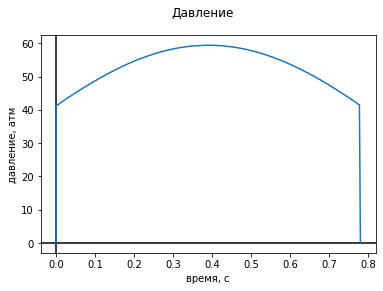

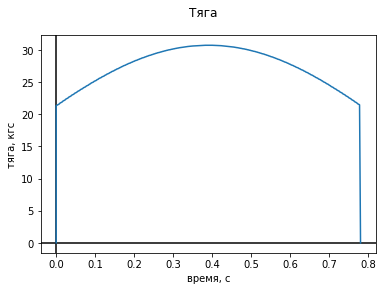

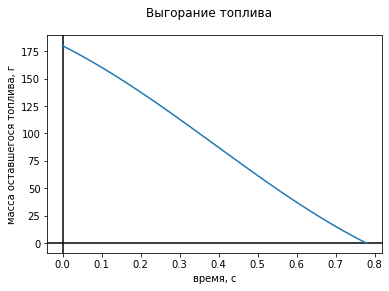

In [8]:
# simulation
# симуляция

def get_fuel_shape(d, hole, l):
    f = numpy.ndarray((int((d - hole) * .5 * dots), int(l * dots)), dtype='uint8')
    f[...] = 1
    if multi_cell:
        f[:, 0] = 2
        f[:, f.shape[1] - 1] = 2
    f[0, :] = 2
    return f
 
@numba.jit
def speed(p):
    return a * p ** n
 
@numba.jit
def step(f, f1):
    n = 0.
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            if f1[i, j] == 2:
                for x, y in [(i, j-1), (i+1, j-1), (i+1, j), (i+1, j+1), (i, j+1), (i-1, j+1), (i-1, j), (i-1, j-1)]:
                    if 0 <= x < f.shape[0] and 0 <= y < f.shape[1]:
                        if f[x, y] == 1:
                            f[x, y] = 2
                n += (i + hole * dots * .5)
                f[i, j] = 0
    return n / dots / 10. * 3.1415926 * 2. / (100. * dots * dots) * density * h
 
f = get_fuel_shape(d, hole, l)
x = step(f, numpy.copy(f))
i = 0
Y = []
while x > 0.:
    Y.append(x)
    i += 1
    x = step(f, numpy.copy(f))
 
mass = sum(Y)
print('масса топлива:', mass, 'г')
 
@numba.jit
def T2(t1, p1, p2, i):
    y = (2. + i) / i
    return t1 * p2 ** (1. - 1. / y) * p1 ** (1. / y - 1.)
 
@numba.jit
def U2(t1, t2, mol, i, R=8.314):
    u22 = R / mol * (i + 2.) * (t1 - t2)
    return math.sqrt(u22)
 
@numba.jit
def P2d(p1, p2, i):
    y = (2. + i) / i
    a = ((y + 1.) * .5) ** (2./(y-1.)) * ((y + 1.) / (y - 1.)) / p1 ** (2./y)
    b = 2. / y * p2 ** (2./y-1.) - (1. + 1. / y) * p2 ** (1./y) / p1 ** (1.-1./y)
    return a * b
 
@numba.jit
def S1_s2_2(p1, p2, i):
    y = (2. + i) / i
    a = ((y + 1.) * .5) ** (2./(y-1.)) * ((y + 1.) / (y - 1.)) / p1 ** (2./y)
    b = p2 ** (2./y) - p2 ** (1./y+1.) / p1 ** (1.-1./y)
    return a * b
 
@numba.jit
def P2(p1, s1, s2, i):
    p2 = p1 * .5
    x = (s1 / s2) ** 2
    k = 0.05
    for _ in range(40):
        dx = P2d(p1, p2, i)
        p2 += (x - S1_s2_2(p1, p2, i)) / dx * k
        if k < 1.: k *= 1.2
    return p2
 
@numba.jit
def M(mol, p2, t2, s2, u2, R=8.314):
    return (mol * p2 / t2 / R) * s2 * u2
 
@numba.jit
def P_u(m, mol, s1, s2, t1, i, R=8.314):
    p1 = 1.
    for _ in range(5):
        p2 = P2(p1, s1, s2, i)
        t2 = T2(t1, p1, p2, i)
        u2 = U2(t1, t2, mol, i, R=R) * nozzle_friction
        m2 = M(mol, p2, t2, s2, u2)
        p1 *= 1. + (m / m2 - 1.)
    return p1, u2
 
X = [0.]
Yp = [0.]
Yt = [0.]
Ym = [0.]
i1 = 0.
i2 = 0
while i1 < i:
    s = 1.
    p = 1.
    for _ in range(20):
        m = Y[int(i1)] * dots * s * speed_k
        p, u = P_u(m * .001, mol * .001, (nozzle_critical ** 2 * 0.25 * math.pi * 10**(-6)), (nozzle_out ** 2 * 0.25 * math.pi * 10**(-6)), t, I)
        p *= 10**(-6)
        s = speed(p)
    i1 += s * dots / states
    X.append(i2 / states)
    Yp.append(p * 9.87)
    Yt.append(u * m * .001 / 9.8 * thrust_loss)
    Ym.append(Ym[-1] - m / states)
    i2 += 1
X.append(i2 / states)
Yp.append(0.)
Yt.append(0.)
Ym.append(Ym[-1])
Ym = [m - Ym[-1] for m in Ym]
 
print('время работы движка:', X[-1], 'с')
print('максимальная тяга:', max(Yt), 'кгс')
print('средняя тяга:', sum(Yt) / len(Yt), 'кгс')
print('максимальное давление:', max(Yp), 'атм')
print('среднее давление:', sum(Yp) / len(Yp), 'атм')
 
fig, ax = pyplot.subplots()
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
fig.suptitle('Давление')
pyplot.xlabel('время, с')
pyplot.ylabel('давление, атм')
pyplot.plot(X, Yp)
pyplot.show()
 
fig, ax = pyplot.subplots()
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
fig.suptitle('Тяга')
pyplot.xlabel('время, с')
pyplot.ylabel('тяга, кгс')
pyplot.plot(X, Yt)
pyplot.show()
 
fig, ax = pyplot.subplots()
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
fig.suptitle('Выгорание топлива')
pyplot.xlabel('время, с')
pyplot.ylabel('масса оставшегося топлива, г')
pyplot.plot(X, Ym)
pyplot.show()

## Ссылки
[Закон горения](http://kia-soft.narod.ru/interests/rockets/theory/burnlow/burnlow.htm)

[Сайт автора закона горения и Rocki-motors](http://kia-soft.narod.ru/)

[Использованная здесь модель сопла - модель Nakka](https://www.nakka-rocketry.net/th_nozz.html)

[Мой канал на YouTube](https://www.youtube.com/GreatBusyBeaver/)

[Видео (не моё) про вторичный воспламеняющий состав](https://youtu.be/mQn43RASYNM)

[Репозиторий с программой на GitHub](https://github.com/busyBeaver1/Rocket_motor_model)

По всем вопросам пишите на почту toegorbezrukov@yandex.ru.